# MazeDrone with TF Agents - 03 Extensive Tests with Logs

This notebook aims to develop an extensive training test, in which we use four different combinations of rewards and register the results in log files. 

The combinations are:
- Only positive reward, except for stuck (0, -5, 10, -1)
- Positive and negative reward, but negative is smaller (-6, -5, 10, -1)
- Positive and negative reward are the same (-10, -5, 10, -1)
- Positive and negative, but negative is bigger (-15, -5, 10, -1)

There will be 10 runs of each. The final result for each combination will be the average. The goal here is to have a solid result to compare aproaches. 

### Setup

In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

from __future__ import absolute_import, division, print_function



import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common

import sys
import gym

2024-09-21 10:28:51.695261: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-21 10:28:51.953187: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-21 10:28:53.045906: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-21 10:28:54.855280: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameters

In [2]:
num_iterations = 10_000 # @param {type:"integer"}

initial_collect_steps = 64  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
#replay_buffer_max_length = 100000  # @param {type:"integer"}
replay_buffer_max_length = 100  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 100  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}

rewards = []
rewards.append({
    'destroyed': 0.,
    'stuck': - 5.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -6.,
    'stuck': - 5.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': - 5.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -15.,
    'stuck': - 5.,
    'reached': 10.,
    'standard': -1.
})

### Environment

In [3]:
sys.path.append('/home/naski/Documents/dev/maze_drone_v02')
import gym_maze # Esta linha precisa estar após o PATH

In [4]:
# Importing custom environment
env_name = 'maze-v0'
env = suite_gym.load(env_name)

# Testing
env.reset()

TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 0.       ,  1.       ,  0.       ,  1.       ,  1.4142135,
       -0.7853982], dtype=float32)})

Usually two environments are instantiated: one for training and one for evaluation.

In [5]:
train_py_env = suite_gym.load(env_name)
# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

## Training Loop

In [6]:
from resources import build_agent, TrainingSession
import pandas as pd


for combination in range(4):
    
    # Agent fully connected layer params 
    fc_layer_params = (200,) 

    for run in range(10):
        print('Combination', combination, ' | Run', run)

        # CREATING/RESETING THE AGENT
        agent = build_agent(fc_layer_params, env, learning_rate, train_env)
        agent.initialize()

        # GENERATE TRAINING SESSION
        session = TrainingSession(env_name, rewards[combination], agent, collect_steps_per_iteration, 
                                num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes)
        
        # TRAINING
        step_log, returns, finished, crashed, stucked, steped, _ = session.train()

        # LOGGING
        df_log = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 'Stuck Counter': stucked, 'Avg Steps/Episode': steped})
        df_log.to_csv(f"logs/01-rewards-combinations/03_comb-{combination+1}-run-{run+1}.csv", index=None, header=True)

        # CLEAR MEMORY
        del(agent)
        del(session)
        del(df_log)


Combination 3  | Run 3
Rewards Updated: {'destroyed': -15.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Rewards Updated: {'destroyed': -15.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Rewards: {'destroyed': -15.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 100
step = 200
step = 300
step = 400
step = 500
step = 600
step = 700
step = 800
step = 900
step = 1000
step = 1100
step = 1200
step = 1300
step = 1400
step = 1500
step = 1600
step = 1700
step = 1800
step = 1900
step = 2000
step = 2100
step = 2200
step = 2300
step = 2400
step = 2500
step = 2600
step = 2700
step = 2800
step = 2900
step = 3000
step = 3100
step = 3200
step = 3300
step = 340

## Visualization

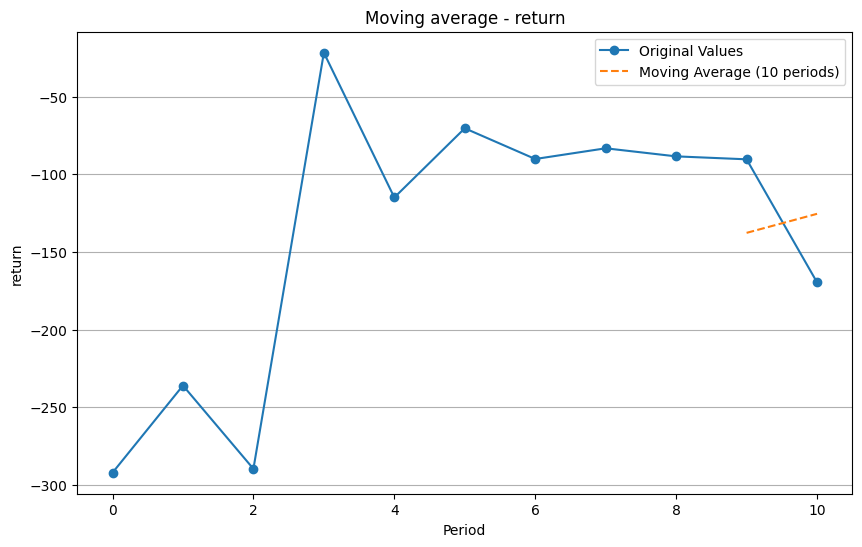

In [18]:
from resources import plot_moving_avg, plot_metric_per_iteration
plot_moving_avg('return', returns)

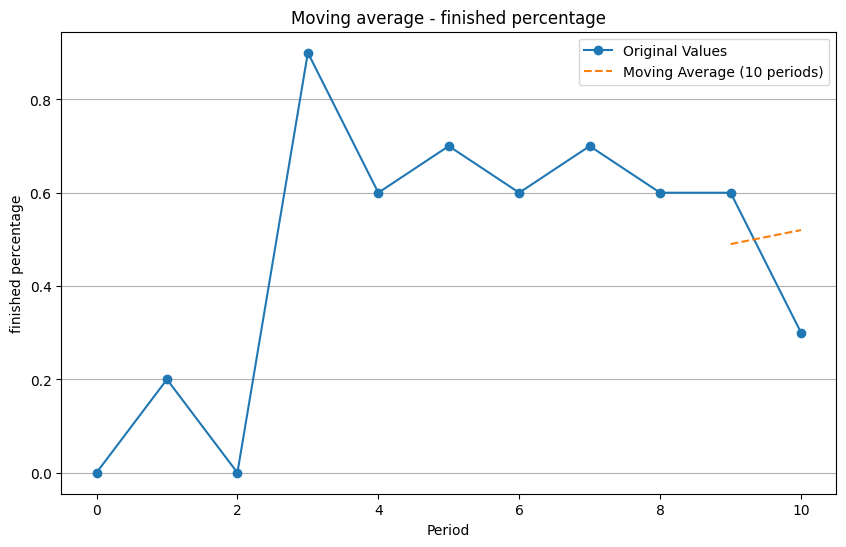

In [19]:
plot_moving_avg('finished percentage', finished)

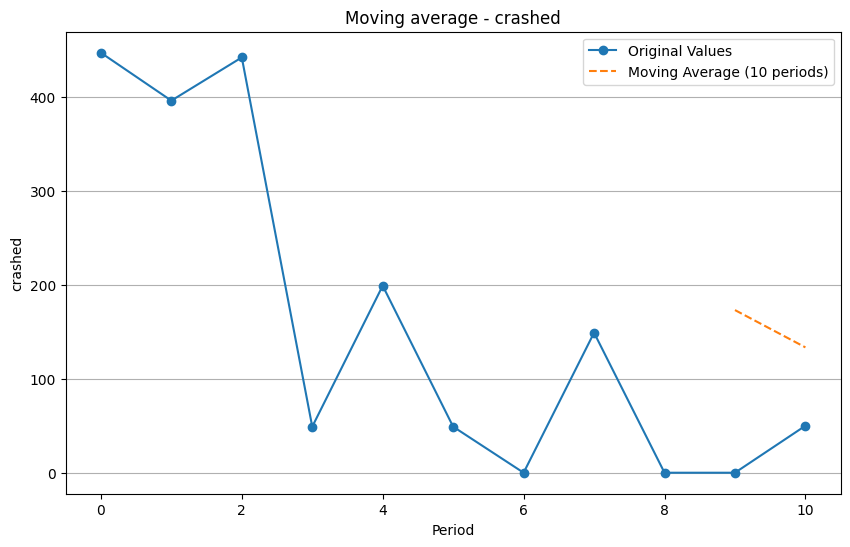

In [26]:
plot_moving_avg('crashed', crashed)

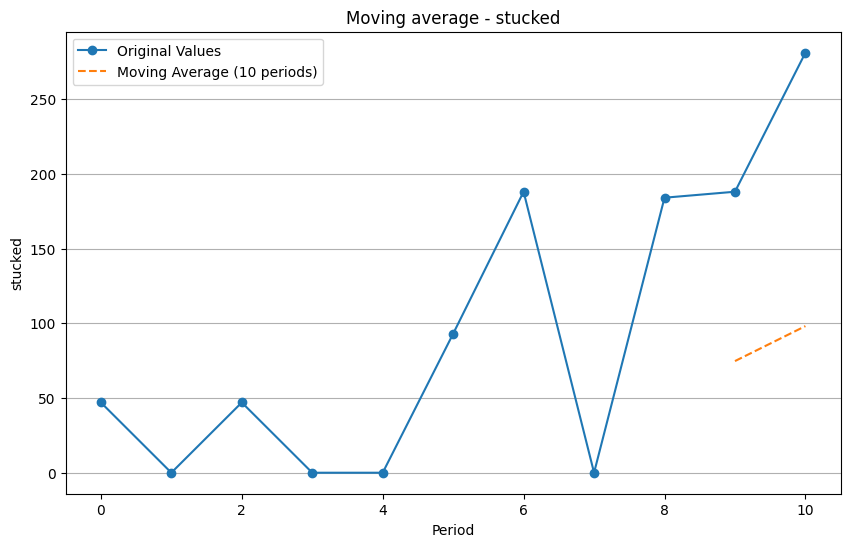

In [27]:
plot_moving_avg('stucked', stucked)

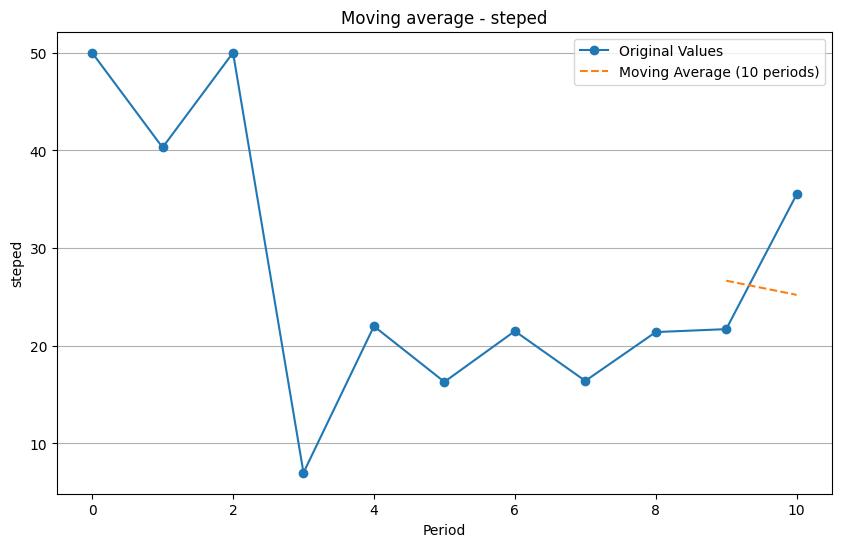

In [28]:
plot_moving_avg('steped', steped)

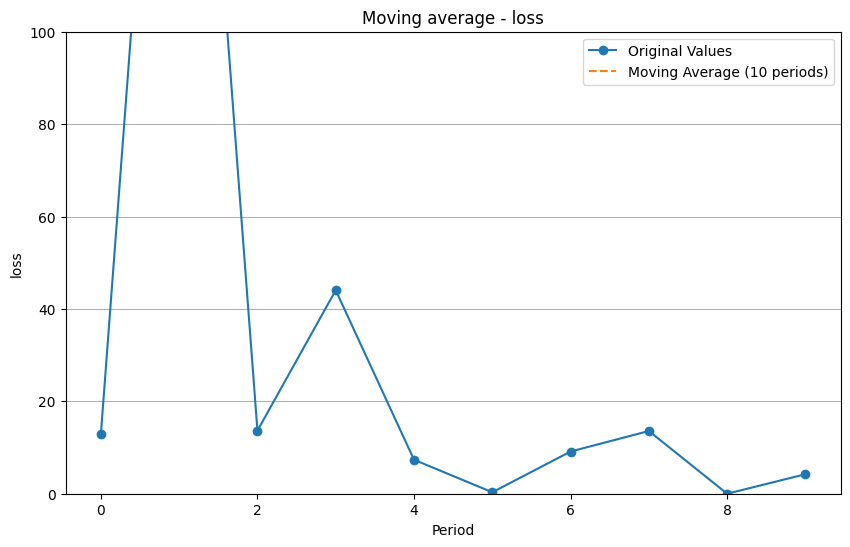

In [57]:
plot_moving_avg('loss', loss_log, ylim=True, top_lim=1_00)

In [55]:
from resources import create_policy_eval_video

# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, "trained-agent", eval_env, eval_py_env)